In [1]:
import os
import re
import gc
import cv2
import h5py
import torch
import string
import random
import numpy as np
import tensorflow as tf

from tqdm import tqdm
from nltk import tokenize
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.chunk import tree2conlltags
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Rescaling, Resizing
from keras import Input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.xception import Xception
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201
from transformers import BertTokenizer, BertForMaskedLM, BertModel
from tensorflow.keras import Model

In [2]:
IMAGE_SIZE = (224, 224)
NUM_CHANNELS = 3

In [3]:
mvsa_single_path = '../input/mvsa-data/mvsa-single-4316.hdf5'
mvsa_multiple_path = '../input/mvsa-data/mvsa-multiple-16387.hdf5'

In [4]:
def clean_text(txt):
#     nonEnglish_regex = re.compile('[^a-zA-Z0-9\\?\\!\\,\\.@#\\+\\-=\\*\'\"><&\\$%\\(\\)\\[\\]:;]+')
#     hashtag_pattern = re.compile('#[a-zA-Z0-9]+')
#     txt_hashtag = re.sub(hashtag_pattern, '', txt)
#     punc_pattern = re.compile('[%s]' % re.escape(string.punctuation))

    at_pattern = re.compile('@[a-zA-Z0-9]+')
    http_pattern = re.compile("((http|ftp|https)://)(([a-zA-Z0-9\._-]+\.[a-zA-Z]{2,6})|([0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}))(:[0-9]{1,4})*(/[a-zA-Z0-9\&%_\./-~-]*)?")
    txt = re.sub(at_pattern, '<user>', txt)
    txt = re.sub(http_pattern, '<link>', txt)
    
    # as the data was crawled using Twitter API, it marked retweet data with RT <user> tag which has no meaning considering it in training
    if txt.startswith('RT <user>'):
        txt = ''.join(txt.split(':')[1:])    
    txt = txt.strip()
    
    return txt

In [5]:
from sklearn.preprocessing import MinMaxScaler

def get_bow(vectorizer, data):
    bow = vectorizer.transform(data).toarray()
    scaler = MinMaxScaler()
    bow_scaled = scaler.fit_transform(bow)
    return bow_scaled

def get_tfidf(vectorizer, data):
    tfidf = vectorizer.transform(data).toarray()
    return tfidf

In [6]:
def get_pos(text):
    tokens_tag = np.array(pos_tag(word_tokenize(text)))
    return tokens_tag[:, 1]

def create_pos_data(data):
    pos_data = []
    for line in tqdm(data):
        try:
            pos = ' '.join(get_pos(line))
        except:
            pos = ''
        pos_data.append(pos)
    return pos_data

In [7]:
def get_ner(text):
    tokens_ne = np.array(tree2conlltags(ne_chunk(pos_tag(word_tokenize(text)))))
    return tokens_ne[:, 2]

def create_ner_data(data):
    ner_data = []
    for line in tqdm(data):
        try:
            ner = ' '.join(get_ner(line))
        except:
            ner = ''
        ner_data.append(ner)
    return ner_data

In [8]:
def get_clean_texts(data):
    cleaned_data = []
    for line in data:
        text = clean_text(line)
        cleaned_data.append(text)
    return cleaned_data

In [9]:
def read_hdf5(path):
    read_file = h5py.File(path, 'r')
    
    feature_names = list(read_file.keys())
    loaded_data = []
    
    for name in feature_names:
        dataset = read_file[name][:]
        if dataset.dtype == np.dtype('object'):
            dataset = np.array([x.decode('UTF-8') for x in dataset])            
        loaded_data.append((name, dataset))

    return loaded_data

In [10]:
def load_mvsa_data(path):
    data = read_hdf5(path)
    for x in data:
        if x[0] == 'texts':
            texts = x[1]
        if x[0] == 'multimodal-labels':
            labels = x[1]
        if x[0] == 'text-labels':
            text_labels = x[1]
        if x[0] == 'image-labels':
            image_labels = x[1]
            
    images_path = os.path.join(os.path.split(path)[0], os.path.split(path)[1].split('.')[0] + '-images.npz')
    images = loadz(images_path)
        
    return texts, images, labels, text_labels, image_labels

def loadz(path):
    data = np.load(path)['arr_0']
    return data

# Load raw data

In [11]:
mvsa_single_texts, mvsa_single_images, \
mvsa_single_multimodal_labels, mvsa_single_text_labels, \
mvsa_single_image_labels = load_mvsa_data(mvsa_single_path)
num_mvsa_single = len(mvsa_single_texts)

mvsa_multiple_texts, mvsa_multiple_images, \
mvsa_multiple_multimodal_labels, mvsa_multiple_text_labels, \
mvsa_multiple_image_labels = load_mvsa_data(mvsa_multiple_path)
num_mvsa_multiple = len(mvsa_multiple_texts)

-----Sample-----
Text label: negative
Image label: negative
Multimodal label: negative
Text: Watching Titanic on Valentine's Day while eating a crap ton of chocolate... I'm just... So ecstatic. Can't you tell?? 
Image:


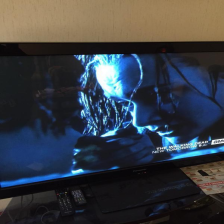

In [12]:
SAMPLE = random.choice(range(num_mvsa_single))
print('-----Sample-----')
print('Text label:', mvsa_single_text_labels[SAMPLE])
print('Image label:', mvsa_single_image_labels[SAMPLE])
print('Multimodal label:', mvsa_single_multimodal_labels[SAMPLE])
print('Text:', mvsa_single_texts[SAMPLE])
print('Image:')
tf.keras.utils.array_to_img(mvsa_single_images[SAMPLE])

-----Sample-----
Text label: negative
Image label: negative
Multimodal label: negative
Text: #HamOnt is a tough town. Don't pay taxes? We cut off your water ;)
Image:


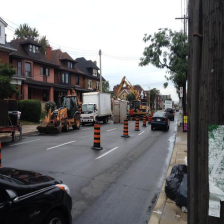

In [13]:
SAMPLE = random.choice(range(num_mvsa_multiple))
print('-----Sample-----')
print('Text label:', mvsa_multiple_text_labels[SAMPLE])
print('Image label:', mvsa_multiple_image_labels[SAMPLE])
print('Multimodal label:', mvsa_multiple_multimodal_labels[SAMPLE])
print('Text:', mvsa_multiple_texts[SAMPLE])
print('Image:')
tf.keras.utils.array_to_img(mvsa_multiple_images[SAMPLE])

# Preprocess text

In [14]:
mvsa_single_texts = get_clean_texts(mvsa_single_texts)
mvsa_multiple_texts = get_clean_texts(mvsa_multiple_texts)

# Labels to file

In [ ]:
with h5py.File('mvsa-single-labels.hdf5', 'w') as f:
    f.create_dataset('multimodal-labels', data = mvsa_single_multimodal_labels.astype('object'))
    f.create_dataset('text-labels', data = mvsa_single_text_labels.astype('object'))
    f.create_dataset('image-labels', data = mvsa_single_image_labels.astype('object'))

In [ ]:
with h5py.File('mvsa-multiple-labels.hdf5', 'w') as f:
    f.create_dataset('multimodal-labels', data = mvsa_multiple_multimodal_labels.astype('object'))
    f.create_dataset('text-labels', data = mvsa_multiple_text_labels.astype('object'))
    f.create_dataset('image-labels', data = mvsa_multiple_image_labels.astype('object'))

# POS

In [15]:
mvsa_single_pos = create_pos_data(mvsa_single_texts)
mvsa_multiple_pos = create_pos_data(mvsa_multiple_texts)

100%|██████████| 16387/16387 [00:24<00:00, 674.24it/s]


In [16]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit(mvsa_single_pos + mvsa_multiple_pos)

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(mvsa_single_pos + mvsa_multiple_pos)

TfidfVectorizer()

In [17]:
mvsa_single_pos_bow = get_bow(count_vectorizer, mvsa_single_pos)
mvsa_multiple_pos_bow = get_bow(count_vectorizer, mvsa_multiple_pos)

mvsa_single_pos_tfidf = get_tfidf(tfidf_vectorizer, mvsa_single_pos)
mvsa_multiple_pos_tfidf = get_tfidf(tfidf_vectorizer, mvsa_multiple_pos)

In [18]:
# save and load check
np.savez('./mvsa-single-pos-bow', mvsa_single_pos_bow)
x = loadz('./mvsa-single-pos-bow.npz')
print((x == mvsa_single_pos_bow).all())

# save and load check
np.savez('./mvsa-multiple-pos-bow', mvsa_multiple_pos_bow)
x = loadz('./mvsa-multiple-pos-bow.npz')
print((x == mvsa_multiple_pos_bow).all())

# save and load check
np.savez('./mvsa-single-pos-tfidf', mvsa_single_pos_tfidf)
x = loadz('./mvsa-single-pos-tfidf.npz')
print((x == mvsa_single_pos_tfidf).all())

# save and load check
np.savez('./mvsa-multiple-pos-tfidf', mvsa_multiple_pos_tfidf)
x = loadz('./mvsa-multiple-pos-tfidf.npz')
print((x == mvsa_multiple_pos_tfidf).all())

True
True
True
True


# NER

In [19]:
mvsa_single_ner = create_ner_data(mvsa_single_texts)
mvsa_multiple_ner = create_ner_data(mvsa_multiple_texts)

100%|██████████| 16387/16387 [02:07<00:00, 128.92it/s]


In [20]:
count_vectorizer2 = CountVectorizer()
count_vectorizer2.fit(mvsa_single_ner + mvsa_multiple_ner)

tfidf_vectorizer2 = TfidfVectorizer()
tfidf_vectorizer2.fit(mvsa_single_ner + mvsa_multiple_ner)

TfidfVectorizer()

In [21]:
mvsa_single_ner_bow = get_bow(count_vectorizer2, mvsa_single_ner)
mvsa_multiple_ner_bow = get_bow(count_vectorizer2, mvsa_multiple_ner)

mvsa_single_ner_tfidf = get_tfidf(tfidf_vectorizer2, mvsa_single_ner)
mvsa_multiple_ner_tfidf = get_tfidf(tfidf_vectorizer2, mvsa_multiple_ner)

In [22]:
# save and load check
np.savez('./mvsa-single-ner-bow', mvsa_single_ner_bow)
x = loadz('./mvsa-single-ner-bow.npz')
print((x == mvsa_single_ner_bow).all())

# save and load check
np.savez('./mvsa-multiple-ner-bow', mvsa_multiple_ner_bow)
x = loadz('./mvsa-multiple-ner-bow.npz')
print((x == mvsa_multiple_ner_bow).all())

# save and load check
np.savez('./mvsa-single-ner-tfidf', mvsa_single_ner_tfidf)
x = loadz('./mvsa-single-ner-tfidf.npz')
print((x == mvsa_single_ner_tfidf).all())

# save and load check
np.savez('./mvsa-multiple-ner-tfidf', mvsa_multiple_ner_tfidf)
x = loadz('./mvsa-multiple-ner-tfidf.npz')
print((x == mvsa_multiple_ner_tfidf).all())

True
True
True
True


# BERT-base

In [ ]:
# MAX_LENGTH = 280 # as in twitter word limit

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')# bert_model = BertForMaskedLM.from_pretrained('bert-base-uncased', return_dict = True)
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
# bert_model.eval() # (evaluation mode is default) put model in evaluation model, turn of regularization in training

In [ ]:
def bert_embed_sentence(text, tokenizer=bert_tokenizer, model=bert_model):
#     inputs = tokenizer(text, return_tensors='pt', max_length=MAX_LENGTH, padding='max_length')
    inputs = tokenizer(text, return_tensors='pt')
    
    with torch.no_grad():
        outputs = model(**inputs, )
        last_hidden_states = outputs.hidden_states[-1][0]
        cls_token = last_hidden_states[0]
        bert_embeddings = torch.squeeze(cls_token, dim=0).numpy()
    
    return bert_embeddings

In [ ]:
def bert_embed_data(data):
    embedded_data = np.array([])
    
    for line in tqdm(data):
        bert_embeddings = bert_embed_sentence(line)
        if embedded_data.shape[0] == 0:
            embedded_data = np.array([bert_embeddings])#np.empty((0, embedded_line.shape[0]), 'float32')
        else:
            embedded_data = np.concatenate((embedded_data, [bert_embeddings]))
            
    return embedded_data

In [ ]:
print('MVSA-Single: Extracting bert features of texts')
mvsa_single_bert_base = bert_embed_data(mvsa_single_texts)
print('BERT-base CLS token in last hidden layer dimension:', mvsa_single_bert_base.shape[1])
print('MVSA-Single with BERT-base CLS token in last hidden layer:', mvsa_single_bert_base.shape)

# save and load check
np.savez('./mvsa-single-bert-base', mvsa_single_bert_base)
x = loadz('./mvsa-single-bert-base.npz')
print((x == mvsa_single_bert_base).all())

In [ ]:
print('MVSA-Multiple: Extracting bert features of texts')
mvsa_multiple_bert_base = bert_embed_data(mvsa_multiple_texts)
print('BERT-base CLS token in last hidden layer dimenion:', mvsa_multiple_bert_base.shape[1])
print('MVSA-Multiple with BERT-base CLS token in last hidden layer:', mvsa_multiple_bert_base.shape)

# save and load check
np.savez('./mvsa-multiple-bert-base', mvsa_multiple_bert_base)
x = loadz('./mvsa-multiple-bert-base.npz')
print((x == mvsa_multiple_bert_base).all())

# VGG-16

In [ ]:
vgg16 = VGG16(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
vgg16.trainable = False # Freeze pre-trained layers
vgg16_last = Model(inputs=vgg16.input, outputs=vgg16.layers[-2].output) # output of last hidden layer

In [ ]:
image_inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
rescale_layer = Rescaling(scale=1./255.) (image_inputs)  # Rescale inputs
outputs = vgg16_last (rescale_layer)
model_vgg16 = Model(inputs=image_inputs, outputs=outputs)

In [ ]:
print('MVSA-Single: Extracting VGG-16 features of images')
mvsa_single_vgg16 = model_vgg16.predict(mvsa_single_images, verbose=1)
print('VGG-16 last hidden layer dimension:', mvsa_single_vgg16.shape[1])
print('MVSA-Single with VGG-16 last hidden layer:', mvsa_single_vgg16.shape)

# save and load check
np.savez('./mvsa-single-vgg16', mvsa_single_vgg16)
x = loadz('./mvsa-single-vgg16.npz')
print((x == mvsa_single_vgg16).all())

In [ ]:
print('MVSA-Multiple: Extracting VGG-16 features of images')
mvsa_multiple_vgg16 = model_vgg16.predict(mvsa_multiple_images, verbose=1)
print('VGG-16 last hidden layer dimension:', mvsa_multiple_vgg16.shape[1])
print('MVSA-Multiple with VGG-16 last hidden layer:', mvsa_multiple_vgg16.shape)

# save and load check
np.savez('./mvsa-multiple-vgg16', mvsa_multiple_vgg16)
x = loadz('./mvsa-multiple-vgg16.npz')
print((x == mvsa_multiple_vgg16).all())

# VGG-19

In [ ]:
vgg19 = VGG19(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
vgg19.trainable = False # Freeze pre-trained layers
vgg19_last = Model(inputs=vgg19.input, outputs=vgg19.layers[-2].output) # output of last hidden layer

# Summary of VGG-19 is hidden
image_inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
rescale_layer = Rescaling(scale=1./255.) (image_inputs)  # Rescale inputs
outputs = vgg19_last (rescale_layer)
model_vgg19 = Model(inputs=image_inputs, outputs=outputs)

In [ ]:
# Summary of VGG-19 is hidden
image_inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
rescale_layer = Rescaling(scale=1./255.) (image_inputs)  # Rescale inputs
outputs = vgg19_last (rescale_layer)
model_vgg19 = Model(inputs=image_inputs, outputs=outputs)

In [ ]:
print('MVSA-Single: Extracting VGG-19 features of images')
mvsa_single_vgg19 = model_vgg19.predict(mvsa_single_images, verbose=1)
print('VGG-19 last hidden layer dimension:', mvsa_single_vgg19.shape[1])
print('MVSA-Single with VGG-19 last hidden layer:', mvsa_single_vgg19.shape)

# save and load check
np.savez('./mvsa-single-vgg19', mvsa_single_vgg19)
x = loadz('./mvsa-single-vgg19.npz')
print((x == mvsa_single_vgg19).all())

In [ ]:
print('MVSA-Multiple: Extracting VGG-19 features of images')
mvsa_multiple_vgg19 = model_vgg19.predict(mvsa_multiple_images, verbose=1)
print('VGG-19 last hidden layer dimension:', mvsa_multiple_vgg19.shape[1])
print('MVSA-Multiple with VGG-19 last hidden layer:', mvsa_multiple_vgg19.shape)

# save and load check
np.savez('./mvsa-multiple-vgg19', mvsa_multiple_vgg19)
x = loadz('./mvsa-multiple-vgg19.npz')
print((x == mvsa_multiple_vgg19).all())

# Xception

In [ ]:
IMAGE_SIZE_XCEPTION = (299, 299)

In [ ]:
xception = Xception(input_shape=(IMAGE_SIZE_XCEPTION[0], IMAGE_SIZE_XCEPTION[1], NUM_CHANNELS))
xception.trainable = False # Freeze pre-trained layers
xception_last = Model(inputs=xception.input, outputs=xception.layers[-2].output) # output of last hidden layer

In [ ]:
# Summary of VGG-19 is hidden
image_inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
resize_layer = Resizing(IMAGE_SIZE_XCEPTION[0], IMAGE_SIZE_XCEPTION[1]) (image_inputs)
rescale_layer = Rescaling(scale=1./255.) (resize_layer)  # Rescale inputs
outputs = xception_last (rescale_layer)
model_xception = Model(inputs=image_inputs, outputs=outputs)
model_xception.summary()

In [ ]:
print('MVSA-Single: Extracting Xception features of images')
mvsa_single_xception = model_xception.predict(mvsa_single_images, verbose=1)
print('Xception last hidden layer dimension:', mvsa_single_xception.shape[1])
print('MVSA-Single with Xception last hidden layer:', mvsa_single_xception.shape)

# save and load check
np.savez('./mvsa-single-xception', mvsa_single_xception)
x = loadz('./mvsa-single-xception.npz')
print((x == mvsa_single_xception).all())

In [ ]:
print('MVSA-Multiple: Extracting Xception features of images')
mvsa_multiple_xception = model_xception.predict(mvsa_multiple_images, verbose=1)
print('Xception last hidden layer dimension:', mvsa_multiple_xception.shape[1])
print('MVSA-Multiple with Xception last hidden layer:', mvsa_multiple_xception.shape)

# save and load check
np.savez('./mvsa-multiple-xception', mvsa_multiple_xception)
x = loadz('./mvsa-multiple-xception.npz')
print((x == mvsa_multiple_xception).all())

# ResNet50

In [ ]:
resnet50 = ResNet50(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
resnet50.trainable = False # Freeze pre-trained layers
resnet50_last = Model(inputs=resnet50.input, outputs=resnet50.layers[-2].output)

In [ ]:
# Summary of VGG-19 is hidden
image_inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
rescale_layer = Rescaling(scale=1./255.) (image_inputs)  # Rescale inputs
outputs = resnet50_last (rescale_layer)
model_resnet50 = Model(inputs=image_inputs, outputs=outputs)

In [ ]:
print('MVSA-Single: Extracting ResNet50 features of images')
mvsa_single_resnet50 = model_resnet50.predict(mvsa_single_images, verbose=1)
print('ResNet50 last hidden layer dimension:', mvsa_single_resnet50.shape[1])
print('MVSA-Single with ResNet50 last hidden layer:', mvsa_single_resnet50.shape)

# save and load check
np.savez('./mvsa-single-resnet50', mvsa_single_resnet50)
x = loadz('./mvsa-single-resnet50.npz')
print((x == mvsa_single_resnet50).all())

In [ ]:
print('MVSA-Multiple: Extracting ResNet50 features of images')
mvsa_multiple_resnet50 = model_resnet50.predict(mvsa_multiple_images, verbose=1)
print('ResNet50 last hidden layer dimension:', mvsa_multiple_resnet50.shape[1])
print('MVSA-Multiple with ResNet50 last hidden layer:', mvsa_multiple_resnet50.shape)

# save and load check
np.savez('./mvsa-multiple-resnet50', mvsa_multiple_resnet50)
x = loadz('./mvsa-multiple-resnet50.npz')
print((x == mvsa_multiple_resnet50).all())

# ResNet101

In [ ]:
resnet101 = ResNet101(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
resnet101.trainable = False # Freeze pre-trained layers
resnet101_last = Model(inputs=resnet101.input, outputs=resnet101.layers[-2].output)

In [ ]:
# Summary of VGG-19 is hidden
image_inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
rescale_layer = Rescaling(scale=1./255.) (image_inputs)  # Rescale inputs
outputs = resnet101_last (rescale_layer)
model_resnet101 = Model(inputs=image_inputs, outputs=outputs)

In [ ]:
print('MVSA-Single: Extracting ResNet101 features of images')
mvsa_single_resnet101 = model_resnet101.predict(mvsa_single_images, verbose=1)
print('ResNet101 last hidden layer dimension:', mvsa_single_resnet101.shape[1])
print('MVSA-Single with ResNet101 last hidden layer:', mvsa_single_resnet101.shape)

# save and load check
np.savez('./mvsa-single-resnet101', mvsa_single_resnet101)
x = loadz('./mvsa-single-resnet101.npz')
print((x == mvsa_single_resnet101).all())

In [ ]:
print('MVSA-Multiple: Extracting ResNet101 features of images')
mvsa_multiple_resnet101 = model_resnet101.predict(mvsa_multiple_images, verbose=1)
print('ResNet101 last hidden layer dimension:', mvsa_multiple_resnet101.shape[1])
print('MVSA-Multiple with ResNet101 last hidden layer:', mvsa_multiple_resnet101.shape)

# save and load check
np.savez('./mvsa-multiple-resnet101', mvsa_multiple_resnet101)
x = loadz('./mvsa-multiple-resnet101.npz')
print((x == mvsa_multiple_resnet101).all())

# ResNet152

In [ ]:
resnet152 = ResNet152(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
resnet152.trainable = False # Freeze pre-trained layers
resnet152_last = Model(inputs=resnet152.input, outputs=resnet152.layers[-2].output)

In [ ]:
# Summary of ResNet52 is hidden
image_inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
rescale_layer = Rescaling(scale=1./255.) (image_inputs)  # Rescale inputs
outputs = resnet152_last (rescale_layer)
model_resnet152 = Model(inputs=image_inputs, outputs=outputs)

In [ ]:
print('MVSA-Single: Extracting ResNet152 features of images')
mvsa_single_resnet152 = model_resnet152.predict(mvsa_single_images, verbose=1)
print('ResNet152 last hidden layer dimension:', mvsa_single_resnet152.shape[1])
print('MVSA-Single with ResNet152 last hidden layer:', mvsa_single_resnet152.shape)

# save and load check
np.savez('./mvsa-single-resnet152', mvsa_single_resnet152)
x = loadz('./mvsa-single-resnet152.npz')
print((x == mvsa_single_resnet152).all())

In [ ]:
print('MVSA-Multiple: Extracting ResNet152 features of images')
mvsa_multiple_resnet152 = model_resnet152.predict(mvsa_multiple_images, verbose=1)
print('ResNet152 last hidden layer dimension:', mvsa_multiple_resnet152.shape[1])
print('MVSA-Multiple with ResNet152 last hidden layer:', mvsa_multiple_resnet152.shape)

# save and load check
np.savez('./mvsa-multiple-resnet152', mvsa_multiple_resnet152)
x = loadz('./mvsa-multiple-resnet152.npz')
print((x == mvsa_multiple_resnet152).all())

# DenseNet121

In [ ]:
densenet121 = DenseNet121(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
densenet121.trainable = False # Freeze pre-trained layers
densenet121_last = Model(inputs=densenet121.input, outputs=densenet121.layers[-2].output)

In [ ]:
# Summary of DenseNet121 is hidden
image_inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
rescale_layer = Rescaling(scale=1./255.) (image_inputs)  # Rescale inputs
outputs = densenet121_last (rescale_layer)
model_densenet121 = Model(inputs=image_inputs, outputs=outputs)

In [ ]:
print('MVSA-Single: Extracting DenseNet121 features of images')
mvsa_single_densenet121 = model_densenet121.predict(mvsa_single_images, verbose=1)
print('DenseNet121 last hidden layer dimension:', mvsa_single_densenet121.shape[1])
print('MVSA-Single with DenseNet121 last hidden layer:', mvsa_single_densenet121.shape)

# save and load check
np.savez('./mvsa-single-densenet121', mvsa_single_densenet121)
x = loadz('./mvsa-single-densenet121.npz')
print((x == mvsa_single_densenet121).all())

In [ ]:
print('MVSA-Multiple: Extracting DenseNet121 features of images')
mvsa_multiple_densenet121 = model_densenet121.predict(mvsa_multiple_images, verbose=1)
print('DenseNet121 last hidden layer dimension:', mvsa_multiple_densenet121.shape[1])
print('MVSA-Multiple with DenseNet121 last hidden layer:', mvsa_multiple_densenet121.shape)

# save and load check
np.savez('./mvsa-multiple-densenet121', mvsa_multiple_densenet121)
x = loadz('./mvsa-multiple-densenet121.npz')
print((x == mvsa_multipledensenet121).all())

# DenseNet169

In [ ]:
densenet169 = DenseNet169(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
densenet169.trainable = False # Freeze pre-trained layers
densenet169_last = Model(inputs=densenet169.input, outputs=densenet169.layers[-2].output)

In [ ]:
# Summary of DenseNet121 is hidden
image_inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
rescale_layer = Rescaling(scale=1./255.) (image_inputs)  # Rescale inputs
outputs = densenet169_last (rescale_layer)
model_densenet169 = Model(inputs=image_inputs, outputs=outputs)

In [ ]:
print('MVSA-Single: Extracting DenseNet169 features of images')
mvsa_single_densenet169 = model_densenet169.predict(mvsa_single_images, verbose=1)
print('DenseNet169 last hidden layer dimension:', mvsa_single_densenet169.shape[1])
print('MVSA-Single with DenseNet169 last hidden layer:', mvsa_single_densenet169.shape)

# save and load check
np.savez('./mvsa-single-densenet169', mvsa_single_densenet169)
x = loadz('./mvsa-single-densenet169.npz')
print((x == mvsa_single_densenet169).all())

In [ ]:
print('MVSA-Multiple: Extracting DenseNet169 features of images')
mvsa_multiple_densenet169 = model_densenet169.predict(mvsa_multiple_images, verbose=1)
print('DenseNet169 last hidden layer dimension:', mvsa_multiple_densenet169.shape[1])
print('MVSA-Multiple with DenseNet169 last hidden layer:', mvsa_multiple_densenet169.shape)

# save and load check
np.savez('./mvsa-multiple-densenet169', mvsa_multiple_densenet169)
x = loadz('./mvsa-multiple-densenet169.npz')
print((x == mvsa_multiple_densenet169).all())

# DenseNet201

In [ ]:
densenet201 = DenseNet201(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
densenet201.trainable = False # Freeze pre-trained layers
densenet201_last = Model(inputs=densenet201.input, outputs=densenet201.layers[-2].output)

In [ ]:
# Summary of DenseNet201 is hidden
image_inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
rescale_layer = Rescaling(scale=1./255.) (image_inputs)  # Rescale inputs
outputs = densenet201_last (rescale_layer)
model_densenet201 = Model(inputs=image_inputs, outputs=outputs)

In [ ]:
print('MVSA-Single: Extracting DenseNet201 features of images')
mvsa_single_densenet201 = model_densenet201.predict(mvsa_single_images, verbose=1)
print('DenseNet201 last hidden layer dimension:', mvsa_single_densenet201.shape[1])
print('MVSA-Single with DenseNet201 last hidden layer:', mvsa_single_densenet201.shape)

# save and load check
np.savez('./mvsa-single-densenet201', mvsa_single_densenet201)
x = loadz('./mvsa-single-densenet201.npz')
print((x == mvsa_single_densenet201).all())

In [ ]:
print('MVSA-Multiple: Extracting DenseNet201 features of images')
mvsa_multiple_densenet201 = model_densenet201.predict(mvsa_multiple_images, verbose=1)
print('DenseNet201 last hidden layer dimension:', mvsa_multiple_densenet201.shape[1])
print('MVSA-Multiple with DenseNet201 last hidden layer:', mvsa_multiple_densenet201.shape)

# save and load check
np.savez('./mvsa-multiple-densenet201', mvsa_multiple_densenet201)
x = loadz('./mvsa-multiple-densenet201.npz')
print((x == mvsa_multiple_densenet201).all())

# Drafts

In [ ]:
# def resize_xception(data):
#     resized_data = []
#     for image in data:
#         image = cv2.resize(image, IMAGE_SIZE_XCEPTION, interpolation = cv2.INTER_AREA)
#         resized_data.append(image)
#     resized_data = np.array(resized_data, dtype='uint8') ##float32
#     return resized_data

# mvsa_single_images_299 = resize_xception(mvsa_single_images)
# mvsa_multiple_images_299 = resize_xception(mvsa_multiple_images)

In [ ]:
# # for loading saved output data
# def load_mvsa_data(path):
#     read_file = h5py.File(path, 'r')
    
#     texts = read_file['texts'][:]
#     texts = np.array([x.decode('UTF-8') for x in texts]) # decode to utf-8 because hd5py save text object as binary string b'' thingy
    
#     images = read_file['images'][:]
    
#     multimodal_labels = read_file['multimodal-labels'][:]
#     multimodal_labels = np.array([x.decode('UTF-8') for x in multimodal_labels])

#     text_labels = read_file['text-labels'][:]
#     text_labels = np.array([x.decode('UTF-8') for x in text_labels])

#     image_labels = read_file['image-labels'][:]
#     image_labels = np.array([x.decode('UTF-8') for x in image_labels])

#     return texts, images, multimodal_labels, text_labels, image_labels

In [ ]:
# def load_data(path):
#     read_file = h5py.File(path, 'r')
#     text_features = read_file['bert-base'][:]
#     image_features_16 = read_file['vgg-16'][:]
#     image_features_19 = read_file['vgg-19'][:]

#     return text_features, image_features_16, image_features_19

In [ ]:
# np.savez('./mvsa-single-texts-bert', mvsa_single_texts_bert)
# npzfile = np.load('./mvsa-single-texts-bert.npz')
# mvsa_single_texts_bert_loaded = npzfile['arr_0']

In [ ]:
## OLD LOAD FILES WITH NUMPY

# def read_text_file(path, multi_line=False):
#     if multi_line == True:
#         lines = open(path, 'r', encoding='latin-1').readlines()
#         lines = [line.rstrip('\n') for line in lines]
#         return lines
#     return open(path, 'r', encoding='latin-1').read()

# mvsa_single_texts = read_text_file('../input/mvsa-data/mvsa-single-data/mvsa-single-texts.txt', multi_line=True)
# mvsa_single_images = np.load('../input/mvsa-data/mvsa-single-data/mvsa-single-images.npy')
# mvsa_single_labels = read_text_file('../input/mvsa-data/mvsa-single-data/mvsa-single-labels.txt', multi_line=True)

In [ ]:
#### OLD BERT SENTENCE EMBED

# # get all token embeddings with padding
# def bert_embed(text, tokenizer=bert_tokenizer, model=bert_model):
#     marked_text = "[CLS] " + text + " [SEP]"
#     tokenized_text = tokenizer.tokenize(marked_text) # Tokenize our sentence with the BERT tokenizer.
#     indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text) # Map the token strings to their vocabulary indeces.
#     padded = pad_sequences([indexed_tokens], maxlen=MAX_LENGTH, padding='post', truncating='post')[0]
#     segments_ids = [1] * MAX_LENGTH
#     tokens_tensor = torch.tensor(np.array([padded]))
#     segments_tensor = torch.tensor(np.array([segments_ids]))

#     with torch.no_grad():
#         outputs = model(tokens_tensor, segments_tensor)

#         # Evaluating the model will return a different number of objects based on 
#         # how it's  configured in the `from_pretrained` call earlier. In this case, 
#         # becase we set `output_hidden_states = True`, the third item will be the 
#         # hidden states from all layers. See the documentation for more details:
#         # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
        
# #         return outputs
# #         print(outputs)
#         hidden_states = outputs[2]
#         last_hidden_states = hidden_states[-1] # get embeddings of every word at last layer
#         print(last_hidden_states)

#         bert_embeddings = torch.squeeze(last_hidden_states, dim=0).numpy()
#     return bert_embeddings

# # text = mvsa_single_texts[0]
# # bert_embed(text).shape

In [ ]:
# bert_embeddings.shape
# outputs[0]
# last_hidden_states = outputs.last_hidden_state

# token_vecs = hidden_states[-2][0]

# # Calculate the average of all 22 token vectors.
# sentence_embedding = torch.mean(token_vecs, dim=0)

In [ ]:
# EMB_DIM = 100
# MAX_WORDS = 1000
# if max_words is not None: 
#     VOCAB_LEN = max_words 
# else:
#     VOCAB_LEN = len(word_index)+1
# embedding_matrix = np.zeros((VOCAB_LEN, EMB_DIM))
# oov_count = 0
# oov_words = []
# for word, idx in word_index.items():
#     if idx < VOCAB_LEN:
#         embedding_vector = embedding_vectors.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[idx] = embedding_vector

In [ ]:
# text = mvsa_single_texts[0]
# inputs = bert_tokenizer(text, return_tensors="pt")
# outputs = bert_model(**inputs)
# last_hidden_states = outputs.last_hidden_state
# bert_embeddings = torch.squeeze(last_hidden_states, dim=0)

In [ ]:
# padded = pad_sequences([inputs['input_ids'][0]], maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')[0]
# inputs['input_ids'] = torch.tensor(padded).to(torch.long)
# mask = np.where(padded == 0, 0, 1)
# inputs['attention_mask'] = torch.tensor(mask)
# token_type_ids = [0] * len(padded)
# inputs['token_type_ids'] = torch.tensor(token_type_ids)

In [ ]:
# encoding = bert_tokenizer.encode_plus(mvsa_single_texts[0], add_special_tokens=True, truncation=True, padding='max_length', return_attention_mask=True, return_tensors="pt")
# tokenized_text = encoding['input_ids'][0]
# attention_mask = encoding["attention_mask"][0]